# Test Env

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


In [3]:
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

lipo_oracle = DGLOracle('GCN_canonical_Lipophilicity')
esol_oracle = DGLOracle('GCN_canonical_ESOL')

Get some data on the deck.

In [4]:
def composite_score(logP, logS):
    import numpy as np
    logP_normalized = np.clip((logP - 2.5) / 3.5, -1, 1)
    logS_normalized = np.clip((logS + 1.5) / 3.5, -1, 1)
    score = (logP_normalized + logS_normalized) / 2
    return score

In [534]:
assays = [lipo_oracle, esol_oracle]
for assay_index, assay in enumerate(assays):
    
    # update library annotations for molecules measured
    results = assay.predict(deck)    
    for molecule_index, molecule in enumerate(deck):
        molecule.update_annotations({f'{assay.model_name}': results[molecule_index]})
        
utility = composite_score(
    deck.annotations['GCN_canonical_Lipophilicity'].values,
    deck.annotations['GCN_canonical_ESOL'].values
)

# housekeeping
best_observed = utility.max()

best_over_time = [best_observed]
dist_over_time = [sorted(utility)[-20:]]

First, set up the environment.

In [535]:
from dgym.envs import DrugEnv

drug_env = DrugEnv(
    library_designer,
    library = deck,
    assays = assays,
    budget = 100_000
)

# # score all molecules
# drug_env.step(
#     {'order': {'assay': 0, 'molecules': range(len(drug_env.library))}}
# )
# drug_env.step(
#     {'order': {'assay': 1, 'molecules': range(len(drug_env.library))}}
# )
print(drug_env.library)

MoleculeCollection with 860 Molecules


Next, define the action mask and start performing assays (randomly).

In [ ]:
import random
import numpy as np

chosen_molecules = utility.argsort()[50:55]

num_rounds = 10
for _ in range(num_rounds):

    # ideate
    action = {
        'design': {
            'molecules': chosen_molecules,
            'num_analogs': 3, # maps to 10 molecules
            'fraction_random': 0.5
        }
    }
    library = drug_env.step(action)[0]

    # score
    assay_results = []
    for assay in assays:
        assay_results.append(np.array(assay.predict(library)))
    utility = composite_score(*assay_results)

    # triage
    chosen_molecules = utility.argsort()[-3:].tolist()
    chosen_molecules.extend(random.sample(range(len(library)), 2))

    # housekeeping
    best_observed = max([*utility, best_observed])
    best_over_time.append(best_observed)
    dist_over_time.append(utility[chosen_molecules])

    # assay
    drug_env.step({'order': {'assay': 0, 'molecules': chosen_molecules}})
    drug_env.step({'order': {'assay': 1, 'molecules': chosen_molecules}})
    print(_, '\t', drug_env.library, '\t', best_observed)
    
    # update model (TODO)

  0%|          | 0/5 [00:00<?, ?it/s]

0 	 MoleculeCollection with 27899 Molecules 	 0.03705857481275285


  0%|          | 0/5 [00:00<?, ?it/s]

1 	 MoleculeCollection with 39408 Molecules 	 0.06914676938738142


  0%|          | 0/5 [00:00<?, ?it/s]

2 	 MoleculeCollection with 48326 Molecules 	 0.09219163869108474


  0%|          | 0/5 [00:00<?, ?it/s]

In [529]:
from dgym.collection import MoleculeCollection

# ideate
results = MoleculeCollection(
    drug_env.design_library(action['design'])
)

# score
assay_results = []
for assay in assays:
    assay_results.append(np.array(assay.predict(results)))
utility = composite_score(*assay_results)

  0%|          | 0/2 [00:00<?, ?it/s]

<Axes: >

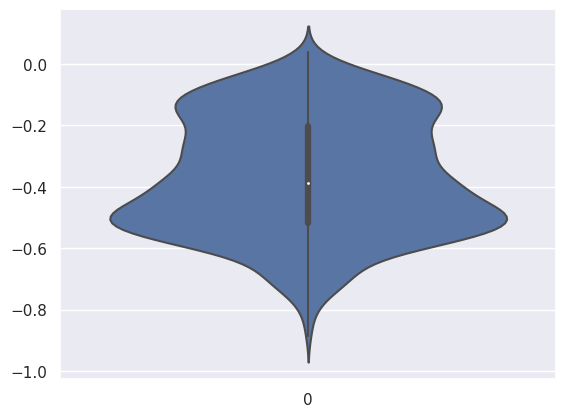

In [530]:
sns.violinplot(utility)

In [531]:
# score
assay_results = []
for assay in assays:
    assay_results.append(np.array(assay.predict(library)))
utility = composite_score(*assay_results)

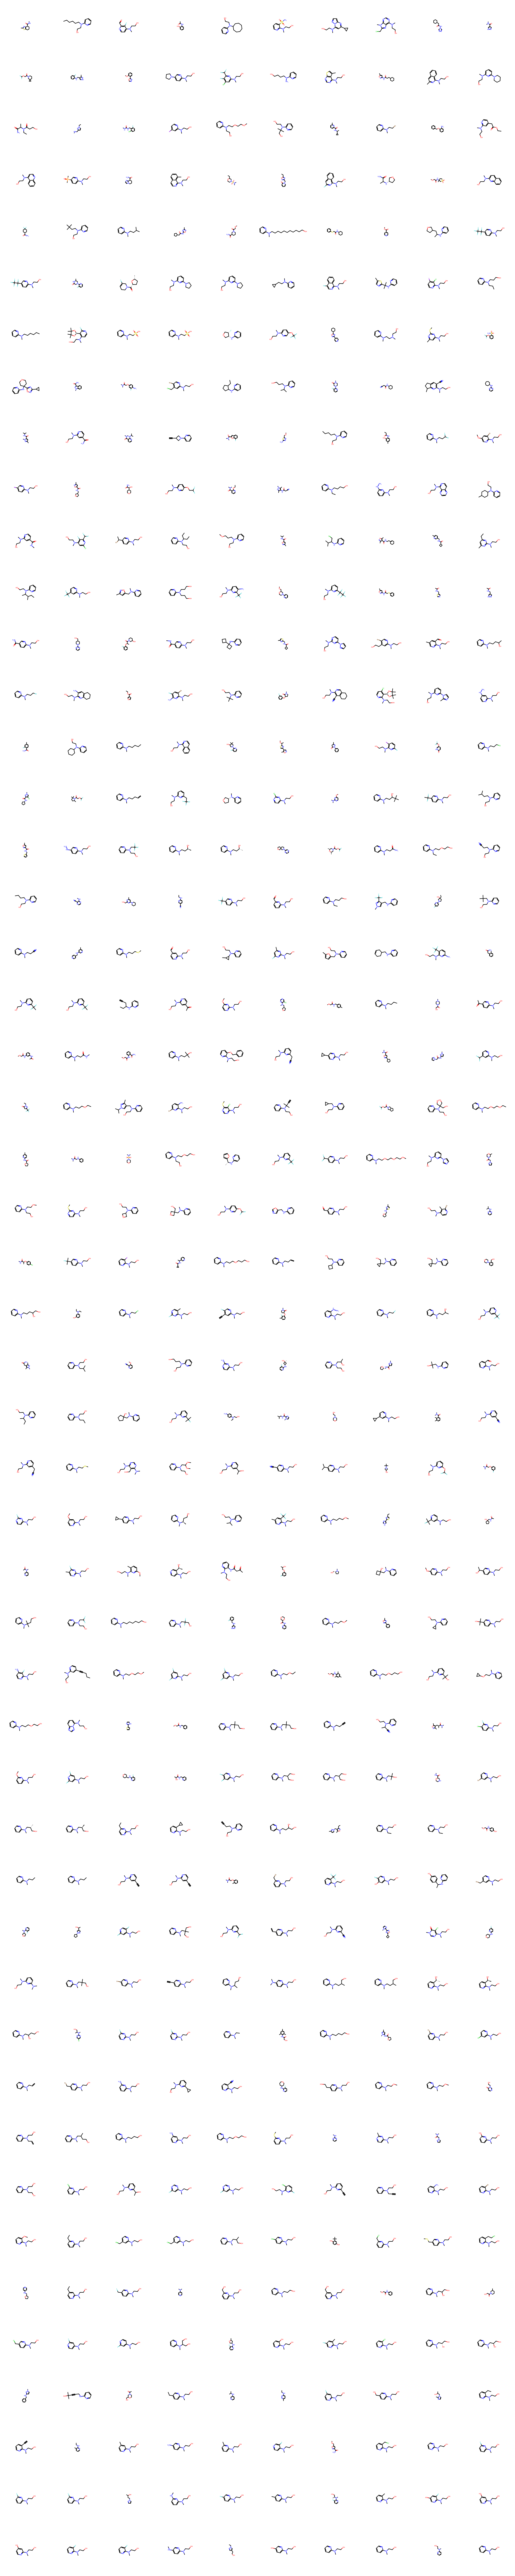

In [532]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(
    [m.update_cache().mol for m in library[utility.argsort()][-500:]],
    molsPerRow=10,
    maxMols=10_000
)

<Axes: >

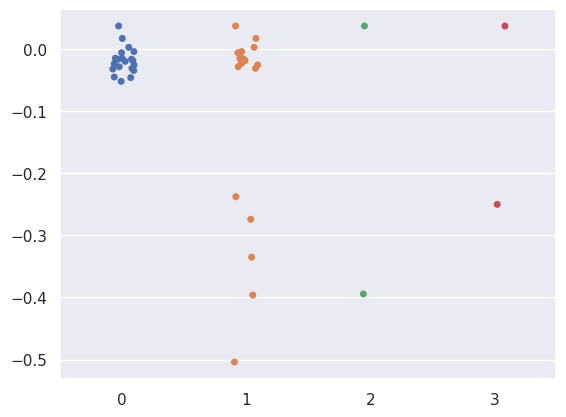

In [533]:
sns.stripplot(dist_over_time)

In [32]:
from dgym.agents import DrugAgent

In [33]:
drug_agent = DrugAgent(drug_env.action_space)